In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from sklearn.model_selection import cross_val_score
from statsmodels.formula.api import ols


In [ ]:
%store -r donnees_2018_hab
%store -r donnees_2018
donnees_2018_hab

In [ ]:
donnees_2018_hab=donnees_2018_hab.drop(columns=['REG', 'Libellé','Crim_Del_PN_GN','Crim_Del_GN_hab','Crim_Del_PN_hab'])



In [ ]:
# donnees_2018_hab=donnees_2018_hab[(donnees_2018_hab.index<'91') & (donnees_2018_hab.index!='75') & (donnees_2018_hab.index!='2A') & (donnees_2018_hab.index!='2B')]

# 1 - Approche économétrique

Dans une première approché économétrique, nous essayons de prédire le nombre de crimes à partir uniquement du nombre de boucherie, puis en rajoutant des variables de contrôles

## 1-A Régression linéaire simple

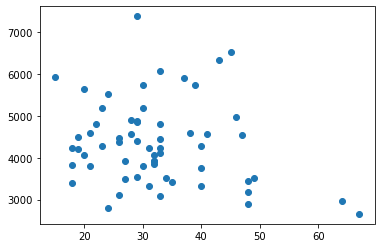

In [141]:
# Code from https://towardsdatascience.com/simulating-replicating-r-regression-plot-in-python-using-sklearn-4ee48a15b67

lm = LinearRegression()


df_train, df_test = train_test_split(donnees_2018_hab, 
                                     train_size = 0.7, 
                                     test_size = 0.3
                                    )

X_train=df_train[[ 'Nb_Boucherie_dep_hab']]
y_train=df_train[['Crim_Del_PN_GN_hab']]

lm.fit(X_train, y_train)

X_test=df_test[['Nb_Boucherie_dep_hab']]
y_test=df_test[['Crim_Del_PN_GN_hab']]

# # for predictions
predictions = lm.predict(X_test)

beta_hat = [lm.intercept_.tolist()] + lm.coef_.tolist()
beta_hat
plt.scatter(X_train, y_train)



In [145]:
reg_with_statsmodels = ols(" Crim_Del_PN_GN_hab ~  Nb_Boucherie_dep_hab", data = df_train).fit()
print(reg_with_statsmodels.summary())

                            OLS Regression Results                            
Dep. Variable:     Crim_Del_PN_GN_hab   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2.655
Date:                Tue, 04 Jan 2022   Prob (F-statistic):              0.109
Time:                        07:47:05   Log-Likelihood:                -505.86
No. Observations:                  61   AIC:                             1016.
Df Residuals:                      59   BIC:                             1020.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4979.9640 

## 1-B Régression linéaire multiple

In [ ]:
# Code from https://towardsdatascience.com/simulating-replicating-r-regression-plot-in-python-using-sklearn-4ee48a15b67

lm = LinearRegression()


df_train, df_test = train_test_split(donnees_2018_hab, 
                                     train_size = 0.7, 
                                     test_size = 0.3
                                    )

X_train=df_train[['MED18', 'TP6018', 'D118', 'D918', 'RD18', 'T1_2018',
       'Nb_PN_GN_dep_100k_hab', 'Nb_Boucherie_dep_hab']]
y_train=df_train[['Crim_Del_PN_GN_hab']]

lm.fit(X_train, y_train)

X_test=df_test[['MED18', 'TP6018', 'D118', 'D918', 'RD18', 'T1_2018',
       'Nb_PN_GN_dep_100k_hab', 'Nb_Boucherie_dep_hab']]
y_test=df_test[['Crim_Del_PN_GN_hab']]

# # for predictions
predictions = lm.predict(X_test)
lm.coef_
lm.intercept_
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores
# R² can be negative with small datasets and cv fold https://stackoverflow.com/questions/23036866/scikit-learn-is-returning-coefficient-of-determination-r2-values-less-than-1

In [ ]:


sns.residplot(predictions.reshape(-1),'Crim_Del_PN_GN_hab', data=df_test,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

In [ ]:
residuals = df_test["Crim_Del_PN_GN_hab"] - predictions.reshape(-1)
residuals

plt.figure(figsize=(7,7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

In [ ]:
model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

plt.figure(figsize=(7,7))
sns.regplot(predictions.reshape(-1), model_norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")

# Hétéroscédasticité
# Woolridge's Introductory Econometrics suggest taking the natural log for : 
# * conditional distributions that are heteroskedastic or skewed;
# * Population variables
# * log(1+y) if 0 exists

In [151]:
formula_reg= " Crim_Del_PN_GN_hab ~  Nb_Boucherie_dep_hab + MED18 + TP6018 + D118 + D918 + RD18 + T1_2018 +    Nb_PN_GN_dep_100k_hab"
reg_with_statsmodels = ols( formula_reg, data = df_train).fit()
print(reg_with_statsmodels.summary())

                            OLS Regression Results                            
Dep. Variable:     Crim_Del_PN_GN_hab   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     8.815
Date:                Tue, 04 Jan 2022   Prob (F-statistic):           1.59e-07
Time:                        07:50:39   Log-Likelihood:                -481.06
No. Observations:                  61   AIC:                             980.1
Df Residuals:                      52   BIC:                             999.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -4.221e+